# 15 Partial Differential Equations — 2

## Solving Laplace's or Poisson's equation

Still solving **Poisson's equation** for the electric potential $\Phi(\mathbf{r})$ and the charge density $\rho(\mathbf{r})$:

$$
\nabla^2 \Phi(x, y, z) = -4\pi\rho(x, y, z)\\
$$

For a region of space without charges ($\rho = 0$) this reduces to **Laplace's equation**

$$
\nabla^2 \Phi(x, y, z) = 0
$$


General solution by iteration:
$$
\Phi_{i,j} = \frac{1}{4}\Big(\Phi_{i+1,j} + \Phi_{i-1,j} + \Phi_{i,j+1} + \Phi_{i,j-1}\Big)
     + \pi\rho_{i,j} \Delta^2
$$

#### Jacobi method
Do not change $\Phi_{i,j}$ until a complete sweep has been completed.

In [11]:
def Laplace_Jacobi_slow(Phi):
    # Don't use, very slow AND inefficient
    Phi_new = Phi.copy()
    Nx, Ny = Phi.shape
    for xi in range(1, Nx-1):
        for yj in range(1, Ny-1):
            Phi_new[xi, yj] = 0.25*(Phi[xi+1, yj] + Phi[xi-1, yj]
                                  + Phi[xi, yj+1] + Phi[xi, yj-1])
    Phi[:, :] = Phi_new
    return Phi

Fast implementation using numpy array operations (vectorized, run at C speed, not Python speed) (see the [board notes (PDF)](https://github.com/ASU-CompMethodsPhysics-PHY494/PHY494-resources/blob/master/16_PDEs/16_PDEs-2-LectureNotes.pdf) or [local PDF](16_PDEs-2-LectureNotes.pdf) for an explanation for how to set up the numpy array operations that give you a 100-fold speed up over `Laplace_Jacobi_slow()`):

In [2]:
def Laplace_Jacobi(Phi):
    """One update in the Jacobi algorithm"""
    Phi[1:-1, 1:-1] = 0.25*(Phi[2:, 1:-1] + Phi[0:-2, 1:-1] + Phi[1:-1, 2:] + Phi[1:-1, 0:-2])
    return Phi

#### Gauss-Seidel method
Immediately use updated new values for $\Phi_{i-1, j}$ and $\Phi_{i, j-1}$ (if starting from $\Phi_{1, 1}$).

Leads to *accelerated convergence* and therefore *less round-off error* (but distorts symmetry of boundary conditions... hopefully irrelevant when converged but check!)

In [3]:
def Laplace_Gauss_Seidel(Phi):
    """One update in the Gauss-Seidel algorithm"""
    Nx, Ny = Phi.shape
    for xi in range(1, Nx-1):
        for yj in range(1, Ny-1):
            Phi[xi, yj] = 0.25*(Phi[xi+1, yj] + Phi[xi-1, yj]
                                + Phi[xi, yj+1] + Phi[xi, yj-1])
    return Phi

#### Fast Gauss-Seidel-like

Divide the lattice into a checkerboard of black and white cells. Update the odd cells first (like Jacobi) but then use the odd cells to update the even ones (Gauss-Seidel-like; see the [board notes (PDF)](https://github.com/ASU-CompMethodsPhysics-PHY494/PHY494-resources/blob/master/16_PDEs/16_PDEs-2-LectureNotes.pdf) or [local PDF](16_PDEs-2-LectureNotes.pdf) ). This leads to faster convergence *and* can be done with numpy array operations.

In [4]:
def Laplace_Gauss_Seidel_odd_even(Phi):
    """One update in the Gauss-Seidel algorithm on odd or even fields"""
    # odd update (uses old even)
    Phi[1:-2:2, 1:-2:2] = 0.25*(Phi[2::2, 1:-2:2] + Phi[0:-2:2, 1:-2:2] + Phi[1:-2:2, 2::2] + Phi[1:-2:2, 0:-2:2])
    Phi[2:-1:2, 2:-1:2] = 0.25*(Phi[3::2, 2:-1:2] + Phi[1:-2:2, 2:-1:2] + Phi[2:-1:2, 3::2] + Phi[2:-1:2, 1:-2:2])
    
    # even update (uses new odd)
    Phi[1:-2:2, 2:-1:2] = 0.25*(Phi[2::2, 2:-1:2] + Phi[0:-2:2, 2:-1:2] + Phi[1:-2:2, 3::2] + Phi[1:-2:2, 1:-1:2])
    Phi[2:-1:2, 1:-2:2] = 0.25*(Phi[3::2, 1:-2:2] + Phi[1:-2:2, 1:-2:2] + Phi[2:-1:2, 2::2] + Phi[2:-1:2, 0:-2:2])
    return Phi

### *Converged* solution of the wire-in-a-box problem

Solve the box-wire problem and **make sure that the solution is converged to  `tol = 1e-3`.**

Check convergence with the [_Frobenius Norm_](http://mathworld.wolfram.com/FrobeniusNorm.html):

$$
||\mathsf{\Phi}|| := \sqrt{\sum_{i,j}|\Phi_{ij}|^2}
$$

which is implemented as [numpy.linalg.norm()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html) when the argument is a matrix.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Interactive plotting (with ipympl):

In [6]:
# for interactive work
%matplotlib widget

Only execute the next line if you *don't* want interactive plotting (e.g., when exporting to LaTeX/PDF or html):

In [21]:
%matplotlib inline

#### Convience plotting functions. 
If you provide a filename then output is only written to a file and figures are close to conserve memory. This allows you to plot files in loops and later assemble them into movies using other programs such as ffmpeg, ImageMagick, mencoder, QuickTime 7, ...

In [7]:
def plot_contour(Phi, filename=None, zlabel=r"potential $\Phi$ (V)",
                 cmap=plt.cm.coolwarm):
    """Plot Phi as a contour plot.
    
    Arguments
    ---------
    Phi : 2D array
          potential on lattice
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    cmap : colormap
          pick one from matplotlib.cm          
    """
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)

    x = np.arange(Phi.shape[0])
    y = np.arange(Phi.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = Phi[X, Y]
    cset = ax.contourf(X, Y, Z, 20, cmap=cmap)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect(1)

    cb = fig.colorbar(cset, shrink=0.5, aspect=5)
    cb.set_label(zlabel)
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax
    

def plot_surf(Phi, filename=None, offset=-20, zlabel=r'potential $\Phi$ (V)',
             elevation=40, azimuth=-65, cmap=plt.cm.coolwarm):
    """Plot Phi as a 3D plot with contour plot underneath.
    
    Arguments
    ---------
    Phi : 2D array
          potential on lattice
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    offset : float, optional (default: 20)
          position the 2D contour plot by offset along the Z direction
          under the minimum Z value
    zlabel : string, optional
          label for the Z axis and color scale bar
    elevation : float, optional
          choose elevation for initial viewpoint
    azimuth : float, optional
          chooze azimuth angle for initial viewpoint
    cmap : colormap
          pick one from matplotlib.cm
    """
     
    x = np.arange(Phi.shape[0])
    y = np.arange(Phi.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = Phi[X, Y]
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, linewidth=0.5, color="gray")
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, alpha=0.6)
    cset = ax.contourf(X, Y, Z, 20, zdir='z', offset=offset+Z.min(), cmap=cmap)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel(zlabel)
    ax.set_zlim(offset + Z.min(), Z.max())
    
    ax.view_init(elev=elevation, azim=azimuth)

    cb = fig.colorbar(surf, shrink=0.5, aspect=5)
    cb.set_label(zlabel)
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax

#### Wire problem

Use the fastest Poisson solver that we have at the moment: `Laplace_Gauss_Seidel_odd_even()`

In [8]:
Max_iter=30000
tol = 1e-3
Nmax = 100
Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

for n_iter in range(Max_iter):
    Phi_old[:, :] = Phi
    Phi = Laplace_Gauss_Seidel_odd_even(Phi)
    DeltaPhi = np.linalg.norm(Phi - Phi_old)
    if DeltaPhi < tol:
        print("Laplace_Gauss_Seidel_odd_even converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
else:
    print("Laplace_Gauss_Seidel_odd_even did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))
    

Laplace_Gauss_Seidel_odd_even converged in 7558 iterations to 0.0009995267090286367


Plot the result and visualy compare to what we had before:

In [9]:
plot_contour(Phi)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
plot_surf(Phi)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Make a movie showing convergence 

The following solution can also write out intermediate solution steps as PNG graphics (commented out for speed). Filenames and directory names are hard-coded.(Important: `plt.ioff()` to disable interactive plotting in the notebook frontend, otherwise it is very slow.)

Put all images into a directory `wire`:

In [10]:
import os, shutil

def mk_new_dir(dirname):
    """Create new directory (remove existing one)"""
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
        print("Removed directory {}".format(dirname))
    os.mkdir(dirname)
    print("Created empty directory {}".format(dirname))
    
mk_new_dir("./wire")

Created empty directory ./wire


Make a movie by saving an image of the potential every 100 steps.

In [11]:
plt.ioff()  # suppress interactive plotting

nsave = 100

Max_iter=30000
tol = 1e-3
Nmax = 100
Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

for n_iter in range(Max_iter):
    Phi_old[:, :] = Phi
    Phi = Laplace_Gauss_Seidel_odd_even(Phi)
    DeltaPhi = np.linalg.norm(Phi - Phi_old)
    if DeltaPhi < tol:
        print("Laplace_Gauss_Seidel_odd_even converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        plot_contour(Phi, filename="wire/phi_{0:08d}.png".format(n_iter))
        break
    if n_iter % nsave == 0:
        print("Iteration {0}".format(n_iter), end="\r")
        plot_contour(Phi, filename="wire/phi_{0:08d}.png".format(n_iter))
else:
    print("Laplace_Gauss_Seidel_odd_even did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))
    
plt.ion()

Laplace_Gauss_Seidel_odd_even converged in 7558 iterations to 0.0009995267090286367


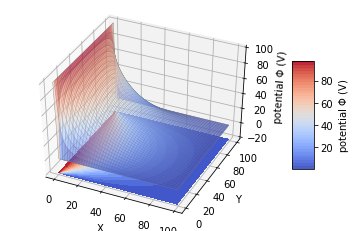

In [12]:
ax = plot_surf(Phi, elevation=40, azimuth=-65)

## Successive Over Relaxation (SOR)
Accelerate convergence with the scheme

\begin{align}
r_{i, j} &= \Phi_{i,j}^\text{new} - \Phi_{i, j}^\text{old}\\
\Phi_{i,j}^\text{new} &= \Phi_{i,j}^\text{old} + \omega r_{i,j}
\end{align}

where the new solution is computed with the Gauss-Seidel scheme.

Values of $1 \leq \omega \leq 2$ may work well, $\omega > 2$ can lead to numerical instabilities. Experiment!

### Solve Wire-in-a-box with SOR 

Run to convergence (tol = 1e-03). Record the number of steps required (and visually check the solution).
* Start with $\omega = 1$. What should you get?
* Change $\omega$ and try to get faster convergence? Who can get it to converge in the fewest number of steps?

In [12]:
Max_iter=10000
tol = 1e-3
Nmax = 100
omega = 1.99

Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)
residual = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

for n_iter in range(Max_iter):
    Phi_old[:, :] = Phi
    Phi = Laplace_Gauss_Seidel_odd_even(Phi)
    residual[:, :] = Phi - Phi_old
    DeltaPhi = np.linalg.norm(residual)
    if DeltaPhi < tol:
        print("SOR converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
    # SOR
    Phi[:, :] = Phi_old + omega*residual  # = omega*Phi + (1-omega)*Phi_old
else:
    print("SOR did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))


SOR converged in 3797 iterations to 0.0009987117944452034


In [13]:
plot_surf(Phi)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Movie of SOR 

Create images in directory `./wire_SOR`

In [15]:
mk_new_dir("./wire_SOR")
mk_new_dir("./wire_SOR_surf")

Created empty directory ./wire_SOR
Created empty directory ./wire_SOR_surf


In [16]:
# %%timeit 
plt.ioff()

nsave = 10

Max_iter=10000
tol = 1e-3
Nmax = 100
omega = 1.99

Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)
residual = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

for n_iter in range(Max_iter):
    Phi_old[:, :] = Phi
    Phi = Laplace_Gauss_Seidel_odd_even(Phi)
    residual[:, :] = Phi - Phi_old
    DeltaPhi = np.linalg.norm(residual)
    if DeltaPhi < tol:
        print("SOR converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        plot_contour(Phi, "wire_SOR/phi_{0:08d}.png".format(n_iter))
        plot_surf(Phi, "./wire_SOR_surf/phi_{0:08d}.png".format(n_iter),
                  elevation=40, azimuth=-65)
        break
    # SOR
    Phi[:, :] = Phi_old + omega*residual # = omega*Phi + (1-omega)*Phi_old
    
    if n_iter % nsave == 0:
        print("Iteration {0}".format(n_iter), end="\r")
        plot_contour(Phi, "./wire_SOR/phi_{0:08d}.png".format(n_iter))
        plot_surf(Phi, "./wire_SOR_surf/phi_{0:08d}.png".format(n_iter),
                  elevation=40, azimuth=-65)

else:
    print("SOR did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))
    
plt.ion()

SOR converged in 3797 iterations to 0.0009987117944452034


### Tuning the code
Alternative implementation that uses more in-place array operations. (However, only marginally faster (~5%) than the previous solution.)

In [28]:
%%timeit 


Max_iter=10000
tol = 1e-3
Nmax = 100
omega = 1.99

Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

for n_iter in range(Max_iter):
    Phi_old[:, :] = Phi
    Phi = Laplace_Gauss_Seidel_odd_even(Phi)
    DeltaPhi = np.linalg.norm(Phi - Phi_old)
    if DeltaPhi < tol:
        print("SOR converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
    # SOR
    # Phi[:, :] = Phi_old + omega*residual  = omega*Phi + (1-omega)*Phi_old
    Phi *= omega
    Phi += (1-omega)*Phi_old
    
    if n_iter % 100 == 0:
        print("Iteration {0}".format(n_iter), end="\r")
else:
    print("SOR did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))
    

SOR converged in 3797 iterations to 0.0009987117944247595
SOR converged in 3797 iterations to 0.0009987117944247595
SOR converged in 3797 iterations to 0.0009987117944247595
SOR converged in 3797 iterations to 0.0009987117944247595
SOR converged in 3797 iterations to 0.0009987117944247595
SOR converged in 3797 iterations to 0.0009987117944247595
SOR converged in 3797 iterations to 0.0009987117944247595
SOR converged in 3797 iterations to 0.0009987117944247595
602 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Simple example of Poisson's equation: Wire and charge
Add a positive charge and a negative charge in the box.

Now we need to solve **Poisson's equation**.

$$
\nabla^2 \Phi(x, y, z) = -4\pi\rho(x, y, z)\\
$$

Finite difference solution:
$$
\Phi_{i,j} = \frac{1}{4}\Big(\Phi_{i+1,j} + \Phi_{i-1,j} + \Phi_{i,j+1} + \Phi_{i,j-1}\Big)
     + \pi\rho_{i,j} \Delta^2
$$

### Poisson Solver 
Modify the Laplace solvers to now solve Poisson's equation:

In [14]:
import numpy as np

def Poisson_Jacobi(Phi, rho, Delta=1.):
    """One update in the Jacobi algorithm for Poisson's equation"""    
    Phi[1:-1, 1:-1] = 0.25*(Phi[2:, 1:-1] + Phi[0:-2, 1:-1] + Phi[1:-1, 2:] + Phi[1:-1, 0:-2]) \
                      + np.pi * Delta**2 * rho[1:-1, 1:-1]
    return Phi

def Poisson_Gauss_Seidel(Phi, rho, Delta=1.):
    """One update in the Gauss-Seidel algorithm for Poisson's equation"""    
    Nx, Ny = Phi.shape
    for xi in range(1, Nx-1):
        for yj in range(1, Ny-1):
            Phi[xi, yj] = 0.25*(Phi[xi+1, yj] + Phi[xi-1, yj]
                                + Phi[xi, yj+1] + Phi[xi, yj-1]) \
                            + np.pi * Delta**2 * rho[xi, yj]
    return Phi

def Poisson_Gauss_Seidel_odd_even(Phi, rho, Delta=1.):
    """One update in the Gauss-Seidel algorithm on odd or even fields"""
    a = np.pi * Delta**2
    # odd update (uses old even)
    Phi[1:-2:2, 1:-2:2] = 0.25*(Phi[2::2, 1:-2:2] + Phi[0:-2:2, 1:-2:2] 
                                + Phi[1:-2:2, 2::2] + Phi[1:-2:2, 0:-2:2]) + a * rho[1:-2:2, 1:-2:2]
    Phi[2:-1:2, 2:-1:2] = 0.25*(Phi[3::2, 2:-1:2] + Phi[1:-2:2, 2:-1:2] 
                                + Phi[2:-1:2, 3::2] + Phi[2:-1:2, 1:-2:2]) + a * rho[2:-1:2, 2:-1:2]
    
    # even update (uses new odd)
    Phi[1:-2:2, 2:-1:2] = 0.25*(Phi[2::2, 2:-1:2] + Phi[0:-2:2, 2:-1:2] 
                                + Phi[1:-2:2, 3::2] + Phi[1:-2:2, 1:-1:2]) + a * rho[1:-2:2, 2:-1:2]
    Phi[2:-1:2, 1:-2:2] = 0.25*(Phi[3::2, 1:-2:2] + Phi[1:-2:2, 1:-2:2] 
                                + Phi[2:-1:2, 2::2] + Phi[2:-1:2, 0:-2:2]) + a * rho[2:-1:2, 1:-2:2]
    return Phi

### Solve wire with dipole 

Solve the Poisson problem with SOR (as above), but now employing the Poisson solvers (we are using the fastest one that we have):

In [15]:
Nmax = 100
Max_iter = 10000
omega = 1.99

Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)
rho = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[:, 0] = 100     # wire at y=0 at 100 V
rho[25:27, 39:41] = 5.0 
rho[75:77, 39:41] = -5.0 

Delta = 1.0

for n_iter in range(Max_iter):
    Phi_old[:, :] = Phi
    Phi = Poisson_Gauss_Seidel_odd_even(Phi, rho, Delta=Delta)
    residual[:, :] = Phi - Phi_old
    DeltaPhi = np.linalg.norm(residual)
    if DeltaPhi < tol:
        print("SOR converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
    # SOR
    Phi[:, :] = Phi_old + omega*residual # = omega*Phi + (1-omega)*Phi_old
else:
    print("SOR did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))

    

SOR converged in 3823 iterations to 0.0009991605868815044


In [16]:
plot_surf(Phi, elevation=40, azimuth=20)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Make a movie 

The following code can write partial solutions as images. To make it a bit more comfortable, we generate a directory for the images from Python:

In [25]:
import os

def makedir(dirname):
    try:
        os.mkdir(dirname)
    except OSError:
        pass
    return dirname

In [27]:
plt.ioff()

nsave = 100

Nmax = 100
Max_iter = 10000
omega = 1.99

dirname = makedir("dipole_wire")
filename = os.path.join(dirname, "phi_{0:08d}.png")

dirname3 = makedir("dipole_wire_3d")
filename3 = os.path.join(dirname3, "phi_{0:08d}.png")

Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)
rho = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[:, 0] = 100     # wire at y=0 at 100 V
rho[25:27, 39:41] = 5.0 
rho[75:77, 39:41] = -5.0 

Delta = 1.0

for n_iter in range(Max_iter):
    Phi_old[:, :] = Phi
    Phi = Poisson_Gauss_Seidel_odd_even(Phi, rho, Delta=Delta)
    residual[:, :] = Phi - Phi_old
    DeltaPhi = np.linalg.norm(residual)
    if DeltaPhi < tol:
        print("SOR converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        plot_contour(Phi, filename=filename.format(n_iter))
        break
    # SOR
    Phi[:, :] = Phi_old + omega*residual # = omega*Phi + (1-omega)*Phi_old
    
    if n_iter % nsave == 0:
        print("Iteration {0}".format(n_iter), end="\r")
        plot_contour(Phi, filename=filename.format(n_iter))
        plot_surf(Phi, filename=filename3.format(n_iter),
                  elevation=40, azimuth=20)
else:
    print("SOR did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))
 
print("Images in {0} and {1}".format(dirname, dirname3))
plt.ion()
    

SOR converged in 3823 iterations to 0.0009991605868815044
Images in dipole_wire and dipole_wire_3d


## Charge density 
Given a potential $\Phi$, Poisson's equation gives the charge density:
$$
\rho(\mathbf{x}) = -\frac{1}{4\pi} \nabla^2\Phi(\mathbf{x})
$$

Discretized Laplacian
$$
\nabla^2 \Phi \approx \frac{\Phi(x+\Delta x,y) + \Phi(x-\Delta x,y) +\Phi(x,y+\Delta y) +\, \Phi(x,y-\Delta y) - 4\Phi(x, y)}{\Delta^2}
$$

In [17]:
def laplacian2d(f, Delta=1):
    """Finite difference approximation of Del^2 f.
        
    Arguments
    ---------
    f : M x N matrix
    Delta : float
    
    Returns
    -------
    M x N matrix, boundaries set to 0
    """
    
    L = np.zeros_like(f, dtype=np.float64)
    L[1:-1, 1:-1] = f[1:-1, 2:] + f[1:-1, 0:-2] + f[2:, 1:-1] + f[0:-2, 1:-1] - 4*f[1:-1, 1:-1]
    return L/Delta**2

def laplacian2dsimple(f, Delta=1):
    L = np.zeros_like(f, dtype=np.float64)
    for i in range(1, L.shape[0]-1):
        for j in range(1, L.shape[1]-1):
            L[i, j] = f[i, j+1] + f[i, j-1] + f[i+1, j] + f[i-1, j] - 4*f[i, j]
    return L/Delta**2

Compute the charge density from the converged potential
$$
\rho(x, y) = -\frac{1}{4\pi} \nabla^2 \Phi(x, y)
$$

In [19]:
rhox = - laplacian2d(Phi)/(4*np.pi)

Does `rhox` show the charges of $+5$ and $-5$ that we introduced with the charge density $\rho$?

In [20]:
print(rhox.min())
print(rhox.max())

-5.000004186724989
5.000000000000001


Indeed, the point charges are recovered from the potential.

Plot the charge density:

In [21]:
plot_contour(rhox, zlabel=r"charge density $\rho$")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The position of the point charges are found correctly but the charge on the wire appear to be absent. This is expected because the Laplacian is not defined on the boundary. If you wanted to see the charge on the wire you would need to include it inside the integration domain and also assign a thickness (e.g., one or two grid cells).

The 3D plot shows the "point" charges as spikes of the size of one grid cell:

In [22]:
plot_surf(rhox, zlabel=r"charge density $\rho$", elevation=20, azimuth=20, offset=-3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The position of the point charges are found correctly but the charge on the wire appear to be absent. The problem is that the Laplacian is not defined on the boundary.

Also, if the charges are only defined on a single grid cell then the 3D visualization is sometimes not able to show it correctly.

#### Testing the implementation of Laplacian 

Making sure that our fancy numpy-version of the Laplacian is producing the same results as the naive implementation with Python loops:

In [21]:
import numpy as np

def test_laplacian2d():
    ftest = np.random.random((200, 200))
    assert np.allclose(laplacian2d(ftest), laplacian2dsimple(ftest))

test_laplacian2d()